In [1]:
import zipfile
import os

In [2]:
!pip install rasterio einops -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 54.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 5.4 MB/s eta 0:00:00


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!wget -O EuroSAT_MS.zip "https://zenodo.org/records/7711810/files/EuroSAT_MS.zip?download=1"
zip_path = '/content/EuroSAT_MS.zip'
extraction_directory = '/content/'  # Current directory; adjust if necessary

# Unzip the file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extraction_directory)

# Delete the ZIP file
os.remove(zip_path)

print(f"Unzipped and removed '{zip_path}' successfully.")

new_directory_path = '/content/EuroSat_np'
os.makedirs(new_directory_path, exist_ok=True)
new_directory_path_2 = '/content/eurosat-ms'
os.makedirs(new_directory_path_2, exist_ok=True)

--2024-04-19 11:20:42--  https://zenodo.org/records/7711810/files/EuroSAT_MS.zip?download=1
Resolving zenodo.org (zenodo.org)... 188.184.98.238, 188.185.79.172, 188.184.103.159, ...
Connecting to zenodo.org (zenodo.org)|188.184.98.238|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2065402329 (1.9G) [application/octet-stream]
Saving to: ‘EuroSAT_MS.zip’

EuroSAT_MS.zip      100%[===================>]   1.92G  17.5MB/s    in 1m 59s  

2024-04-19 11:22:41 (16.6 MB/s) - ‘EuroSAT_MS.zip’ saved [2065402329/2065402329]

Unzipped and removed '/content/EuroSAT_MS.zip' successfully.


In [5]:
def count_files_in_subdirectories(directory):
    if not os.path.exists(directory):
        print(f"The directory {directory} does not exist.")
        return

    for root, dirs, files in os.walk(directory):
        print(f"Directory: {root}")
        print("Number of files:", len(files))

# Example usage
directory_path = '/content/EuroSAT_MS'
count_files_in_subdirectories(directory_path)

Directory: /content/EuroSAT_MS
Number of files: 0
Directory: /content/EuroSAT_MS/Residential
Number of files: 3000
Directory: /content/EuroSAT_MS/Forest
Number of files: 3000
Directory: /content/EuroSAT_MS/PermanentCrop
Number of files: 2500
Directory: /content/EuroSAT_MS/HerbaceousVegetation
Number of files: 3000
Directory: /content/EuroSAT_MS/Pasture
Number of files: 2000
Directory: /content/EuroSAT_MS/Industrial
Number of files: 2500
Directory: /content/EuroSAT_MS/SeaLake
Number of files: 3000
Directory: /content/EuroSAT_MS/River
Number of files: 2500
Directory: /content/EuroSAT_MS/Highway
Number of files: 2500
Directory: /content/EuroSAT_MS/AnnualCrop
Number of files: 3000


In [7]:
%run /content/drive/MyDrive/Master_Thesis/image_to_numpy.py

In [8]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from torchsummary import summary
from torchvision.utils import save_image
from transformers import ViTModel, ViTConfig, ViTForImageClassification
from sklearn.model_selection import StratifiedShuffleSplit
import random
import torch.nn.functional as F
import einops
import matplotlib.pyplot as plt
from torch import nn
from torch import Tensor
from PIL import Image
from torchvision.transforms import Compose, Resize, ToTensor
from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange, Reduce
from torchsummary import summary
import time
import torch.optim as optim
from tqdm import tqdm

# set the path to the directory containing the npy files
data_dir = '/content/EuroSat_np'

# set the path to save the trained model
model_path = '/content/eurosat-ms'

# Function to create a simple model for embedding watermarks
def create_embedding_model():
    # A convolutional layer that slightly alters the pixel values to embed the watermark
    model = torch.nn.Conv2d(13, 13, kernel_size=3, padding=1, bias=False)
    torch.nn.init.normal_(model.weight, mean=0, std=0.01)  # Initialize weights to embed subtle patterns
    return model

def apply_watermark(image_array):
    model = create_embedding_model()
    model.eval()  # Set model to evaluation mode

    with torch.no_grad():  # Disable gradient computation
        # Ensure the input numpy array is in the expected format [height, width, channels]
        # Convert and rearrange to 'channels first'
        image_tensor = torch.tensor(image_array, dtype=torch.float32)
        if image_tensor.shape[2] == 3 or image_tensor.shape[2] == 13:  # Assuming RGB or 13-channel input
            image_tensor = rearrange(image_tensor, 'h w c -> c h w')
        else:
            raise ValueError("Unexpected channel count in input array")
        # Apply the model
        watermarked_tensor = model(image_tensor.unsqueeze(0)).squeeze(0)
        # If needed, rearrange back to 'channels last' for compatibility with other functions
        watermarked_tensor = rearrange(watermarked_tensor, 'c h w -> h w c')
        return watermarked_tensor.numpy()



In [9]:
# Load data
X, y = [], []
for i in range(10):  # X0.npy through X9.npy and corresponding y files.
    X_i = np.load(f'{data_dir}/X{i}.npy')
    y_i = np.load(f'{data_dir}/y{i}.npy')

    # Debug: Print the shape of each loaded part
    print(f'X{i}.npy shape: {X_i.shape}')

    X.append(X_i)
    y.append(y_i)

# Concatenate all parts into a single array
X = np.concatenate(X, axis=0)
y = np.concatenate(y, axis=0)

# Final check on the full dataset
print("Total images loaded: ", X.shape)
print("Total labels loaded: ", y.shape)

X0.npy shape: (3000, 64, 64, 13)
X1.npy shape: (3000, 64, 64, 13)
X2.npy shape: (3000, 64, 64, 13)
X3.npy shape: (2500, 64, 64, 13)
X4.npy shape: (2500, 64, 64, 13)
X5.npy shape: (2000, 64, 64, 13)
X6.npy shape: (2500, 64, 64, 13)
X7.npy shape: (3000, 64, 64, 13)
X8.npy shape: (2500, 64, 64, 13)
X9.npy shape: (3000, 64, 64, 13)
Total images loaded:  (27000, 64, 64, 13)
Total labels loaded:  (27000,)


In [10]:
DATASET = "/content/EuroSAT_MS/"

LABELS = os.listdir(DATASET)
print(LABELS)

['Residential', 'Forest', 'PermanentCrop', 'HerbaceousVegetation', 'Pasture', 'Industrial', 'SeaLake', 'River', 'Highway', 'AnnualCrop']


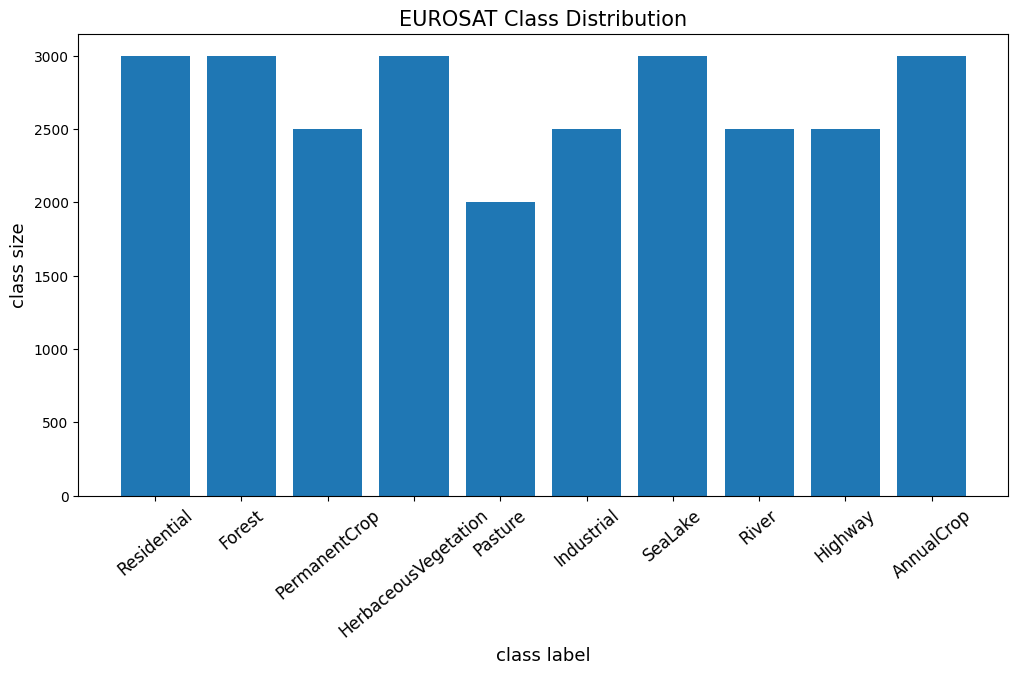

In [11]:
# plot class distributions of whole dataset
counts = {}

for l in LABELS:
    counts[l] = len(os.listdir(os.path.join(DATASET, l)))


plt.figure(figsize=(12, 6))

plt.bar(range(len(counts)), list(counts.values()), align='center')
plt.xticks(range(len(counts)), list(counts.keys()), fontsize=12, rotation=40)
plt.xlabel('class label', fontsize=13)
plt.ylabel('class size', fontsize=13)
plt.title('EUROSAT Class Distribution', fontsize=15);

In [12]:
print(X.shape)

#X = rearrange(X, 'b h w c -> b c h w')

#print(X.shape)

(27000, 64, 64, 13)


In [13]:
# split the data into training and testing sets
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# split the data
for train_idx, test_idx in split.split(X, y):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

In [14]:
class EuroSATDataset(Dataset):
    def __init__(self, X, y, watermark_prob=0.5):
        self.X = X
        self.y = y
        self.watermark_prob = watermark_prob
        self.watermarks = np.random.rand(len(X)) < watermark_prob

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        image = self.X[idx]
        landscape_label = self.y[idx]
        watermark_label = self.watermarks[idx]

        # Apply watermark if flagged
        if watermark_label:
            image = apply_watermark(image)

        # Convert the image to a tensor and rearrange to 'channels first'
        image = torch.from_numpy(image).float()
        image = image.permute(2, 0, 1)  # Ensuring channels first format

        landscape_label = torch.tensor(landscape_label, dtype=torch.long)
        return image, landscape_label, watermark_label

    def save_dataset_images(dataset, root_dir):
    # Iterate over the dataset with a progress bar
      for i in tqdm(range(len(dataset)), desc="Saving images"):
        image, landscape_label, watermark_label = dataset[i]
        label_name = labels[landscape_label]  # Assuming landscape_label is the index in the labels list

        # Determine the subfolder based on the watermark label
        subfolder = "watermarked" if watermark_label else "non_watermarked"
        file_path = os.path.join(root_dir, label_name, subfolder, f"{i}.png")

        # Save the image
        save_image(image, file_path)

# Create the DataLoader for both training and testing datasets
train_dataset = EuroSATDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = EuroSATDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
# set the device to use for training and testing
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [15]:
print(len(train_loader))

675


In [16]:
print(len(test_loader))

169


In [17]:
root_dir = "/content/EuroSAT_MS/"
labels = ['Forest', 'HerbaceousVegetation', 'AnnualCrop', 'Industrial', 'PermanentCrop', 'SeaLake', 'Residential', 'River', 'Pasture', 'Highway']

# Create a directory for each label and subdirectories for watermarked and non-watermarked
for label in labels:
    os.makedirs(os.path.join(root_dir, label, "watermarked"), exist_ok=True)
    os.makedirs(os.path.join(root_dir, label, "non_watermarked"), exist_ok=True)


# Vit blocks

In [18]:
class PatchEmbedding(nn.Module):
    def __init__(self, in_channels: int = 3, patch_size: int = 16, emb_size: int = 768, img_size: int = 224):
        self.patch_size = patch_size
        super().__init__()
        self.projection = nn.Sequential(
            # using a conv layer instead of a linear one -> performance gains
            nn.Conv2d(in_channels, emb_size, kernel_size=patch_size, stride=patch_size),
            Rearrange('b e (h) (w) -> b (h w) e'),
        )
        self.cls_token = nn.Parameter(torch.randn(1,1, emb_size))
        self.positions = nn.Parameter(torch.randn((img_size // patch_size) **2 + 1, emb_size))


    def forward(self, x: Tensor) -> Tensor:
        b, _, _, _ = x.shape
        x = self.projection(x)
        cls_tokens = repeat(self.cls_token, '() n e -> b n e', b=b)
        # prepend the cls token to the input
        x = torch.cat([cls_tokens, x], dim=1)
        # add position embedding
        x += self.positions
        return x



In [19]:
class MultiHeadAttention(nn.Module):
    def __init__(self, emb_size: int = 768, num_heads: int = 8, dropout: float = 0):
        super().__init__()
        self.emb_size = emb_size
        self.num_heads = num_heads
        # fuse the queries, keys and values in one matrix
        self.qkv = nn.Linear(emb_size, emb_size * 3)
        self.att_drop = nn.Dropout(dropout)
        self.projection = nn.Linear(emb_size, emb_size)

    def forward(self, x : Tensor, mask: Tensor = None) -> Tensor:
        # split keys, queries and values in num_heads
        qkv = rearrange(self.qkv(x), "b n (h d qkv) -> (qkv) b h n d", h=self.num_heads, qkv=3)
        queries, keys, values = qkv[0], qkv[1], qkv[2]
        # sum up over the last axis
        energy = torch.einsum('bhqd, bhkd -> bhqk', queries, keys) # batch, num_heads, query_len, key_len
        if mask is not None:
            fill_value = torch.finfo(torch.float32).min
            energy.mask_fill(~mask, fill_value)

        scaling = self.emb_size ** (1/2)
        att = F.softmax(energy, dim=-1) / scaling
        att = self.att_drop(att)
        # sum up over the third axis
        out = torch.einsum('bhal, bhlv -> bhav ', att, values)
        out = rearrange(out, "b h n d -> b n (h d)")
        out = self.projection(out)
        return out



In [20]:
class ResidualAdd(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, **kwargs):
        res = x
        x = self.fn(x, **kwargs)
        x += res
        return x

In [21]:
class FeedForwardBlock(nn.Sequential):
    def __init__(self, emb_size: int, expansion: int = 4, drop_p: float = 0.):
        super().__init__(
            nn.Linear(emb_size, expansion * emb_size),
            nn.GELU(),
            nn.Dropout(drop_p),
            nn.Linear(expansion * emb_size, emb_size),
        )

In [22]:
class TransformerEncoderBlock(nn.Sequential):
    def __init__(self,
                 emb_size: int = 768,
                 drop_p: float = 0.,
                 forward_expansion: int = 4,
                 forward_drop_p: float = 0.,
                 ** kwargs):
        super().__init__(
            ResidualAdd(nn.Sequential(
                nn.LayerNorm(emb_size),
                MultiHeadAttention(emb_size, **kwargs),
                nn.Dropout(drop_p)
            )),
            ResidualAdd(nn.Sequential(
                nn.LayerNorm(emb_size),
                FeedForwardBlock(
                    emb_size, expansion=forward_expansion, drop_p=forward_drop_p),
                nn.Dropout(drop_p)
            )
            ))

In [23]:
class TransformerEncoder(nn.Sequential):
    def __init__(self, depth: int = 12, **kwargs):
        super().__init__(*[TransformerEncoderBlock(**kwargs) for _ in range(depth)])


In [24]:
class ClassificationHead(nn.Sequential):
    def __init__(self, emb_size: int = 768, n_classes: int = 1000):
        super().__init__(
            Reduce('b n e -> b e', reduction='mean'),
            nn.LayerNorm(emb_size),
            nn.Linear(emb_size, n_classes))

In [25]:
class ViT(nn.Sequential):
    def __init__(self,
                in_channels: int = 13,
                patch_size: int = 16,
                emb_size: int = 768,
                img_size: int = 64,
                depth: int = 12,
                n_classes: int = 10,
                **kwargs):
        super().__init__(
            PatchEmbedding(in_channels, patch_size, emb_size, img_size),
            TransformerEncoder(depth, emb_size=emb_size, **kwargs),
            ClassificationHead(emb_size, n_classes)
        )


In [26]:
summary(ViT().cuda(), (13, 64, 64), device='cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 768, 4, 4]       2,556,672
         Rearrange-2              [-1, 16, 768]               0
    PatchEmbedding-3              [-1, 17, 768]               0
         LayerNorm-4              [-1, 17, 768]           1,536
            Linear-5             [-1, 17, 2304]       1,771,776
           Dropout-6            [-1, 8, 17, 17]               0
            Linear-7              [-1, 17, 768]         590,592
MultiHeadAttention-8              [-1, 17, 768]               0
           Dropout-9              [-1, 17, 768]               0
      ResidualAdd-10              [-1, 17, 768]               0
        LayerNorm-11              [-1, 17, 768]           1,536
           Linear-12             [-1, 17, 3072]       2,362,368
             GELU-13             [-1, 17, 3072]               0
          Dropout-14             [-1, 1

In [27]:
model = ViT()
model=model.cuda()

In [28]:
learning_rate = 0.001

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

num_epochs = 10


In [29]:
print(torch.cuda.is_available())

True


In [30]:
train_losses = []
train_accu = []

def train(epoch):
    print('Epoch : %d'%epoch)

    model.train()
    running_loss=0
    correct=0
    total=0
    for images, landscape_labels, _ in tqdm(train_loader):
        images = images.float().cuda()
        landscape_labels = landscape_labels.float().cuda()
        #print(images.size())
        #print(labels.size())
        # Forward pass
        #model = model.cuda()
        outputs = model(images)
        labels1= np.zeros((32,10))

        #labels1 = tensor.detach().cpu().numpy()
        for j in range(32):
            i=landscape_labels[j]
            i=int(i.item())
            # print(i)
            labels1[j][i]=1
        labels1=torch.from_numpy(labels1)
        #print(labels1.size())
        labels1=labels1.to(device='cuda')
        loss = criterion(outputs, labels1)


       # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


    #Replaces pow(2.0) with abs() for L1 regularization

#     l2_lambda = 0.001
#     l2_norm = sum(p.pow(2.0).sum()
#                   for p in model.parameters())

#     loss = loss + l2_lambda * l2_norm


        running_loss += loss.item()

        _, predicted = outputs.max(1)
        total += landscape_labels.size(0)
        correct += predicted.eq(landscape_labels).sum().item()

    train_loss=running_loss/len(train_loader)
    accu=100.*correct/total

    train_accu.append(accu)
    train_losses.append(train_loss)
    print('Train Loss: %.3f | Accuracy: %.3f'%(train_loss,accu))


In [31]:
eval_losses=[]
eval_accu=[]

def test(epoch):
    model.eval()

    running_loss=0
    correct=0
    total=0
    #print(test_loader)
    with torch.no_grad():
        for images, landscape_labels, _ in tqdm(train_loader):
            #images = images.to(device='cuda', dtype=torch.float)
            images = images.float().cuda()
            landscape_labels = landscape_labels.float().cuda()
            #labels = labels.to(device='cuda', dtype=torch.float)

            # Predict classes using the model
            outputs = model(images)
            #print(labels.size())
            t,y=outputs.shape
            # print(t)
            labels1= np.zeros((t,10))
            for j in range(t):
                i=landscape_labels[j]
                i=int(i.item())
                labels1[j][i]=1
            labels1=torch.from_numpy(labels1)
            #print(labels1.size())
            labels1=labels1.to(device='cuda')
            #outputs=outputs.tensor()
            loss= criterion(outputs,labels1)
            running_loss+=loss.item()


           # Compute accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += landscape_labels.size(0)
            correct += (predicted == landscape_labels).sum().item()

    test_loss=running_loss/len(test_loader)
    accu=100.*correct/total

    eval_losses.append(test_loss)
    eval_accu.append(accu)

    print('Test Loss: %.3f | Accuracy: %.3f'%(test_loss,accu))


In [32]:
epochs = 30

# Start the timer
output_dir = '/content/drive/MyDrive/Master_Thesis'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

start_time = time.time()
for epoch in range(1,epochs+1):
    train(epoch)
    # Save the model after training
    torch.save(model.state_dict(), os.path.join(output_dir, f'base_model_train_epoch_{epoch}.pth'))
    test(epoch)
    # Save the model after testing
    torch.save(model.state_dict(), os.path.join(output_dir, f'base_model_test_epoch_{epoch}.pth'))
# End the timer
end_time = time.time()

# Calculate the training time
training_time = end_time - start_time

print('Training time: {:.2f} seconds'.format(training_time))

Epoch : 1


100%|██████████| 675/675 [00:35<00:00, 18.78it/s]


Train Loss: 2.016 | Accuracy: 28.009


100%|██████████| 675/675 [00:18<00:00, 36.18it/s]


Test Loss: 7.018 | Accuracy: 32.324
Epoch : 2


100%|██████████| 675/675 [00:36<00:00, 18.52it/s]


Train Loss: 1.660 | Accuracy: 37.532


100%|██████████| 675/675 [00:18<00:00, 36.20it/s]


Test Loss: 6.404 | Accuracy: 39.569
Epoch : 3


100%|██████████| 675/675 [00:36<00:00, 18.64it/s]


Train Loss: 1.577 | Accuracy: 42.019


100%|██████████| 675/675 [00:19<00:00, 35.06it/s]


Test Loss: 6.244 | Accuracy: 43.523
Epoch : 4


100%|██████████| 675/675 [00:35<00:00, 18.77it/s]


Train Loss: 1.583 | Accuracy: 42.282


100%|██████████| 675/675 [00:18<00:00, 36.62it/s]


Test Loss: 6.192 | Accuracy: 42.560
Epoch : 5


100%|██████████| 675/675 [00:35<00:00, 18.91it/s]


Train Loss: 1.594 | Accuracy: 41.847


100%|██████████| 675/675 [00:18<00:00, 36.39it/s]


Test Loss: 6.157 | Accuracy: 42.301
Epoch : 6


100%|██████████| 675/675 [00:35<00:00, 18.78it/s]


Train Loss: 1.509 | Accuracy: 44.569


100%|██████████| 675/675 [00:18<00:00, 36.50it/s]


Test Loss: 5.831 | Accuracy: 45.190
Epoch : 7


100%|██████████| 675/675 [00:35<00:00, 18.78it/s]


Train Loss: 1.419 | Accuracy: 47.472


100%|██████████| 675/675 [00:19<00:00, 35.43it/s]


Test Loss: 5.481 | Accuracy: 50.662
Epoch : 8


100%|██████████| 675/675 [00:35<00:00, 18.80it/s]


Train Loss: 1.371 | Accuracy: 49.741


100%|██████████| 675/675 [00:18<00:00, 36.50it/s]


Test Loss: 5.374 | Accuracy: 50.366
Epoch : 9


100%|██████████| 675/675 [00:35<00:00, 18.81it/s]


Train Loss: 1.381 | Accuracy: 49.306


100%|██████████| 675/675 [00:18<00:00, 36.42it/s]


Test Loss: 6.195 | Accuracy: 41.884
Epoch : 10


100%|██████████| 675/675 [00:35<00:00, 18.80it/s]


Train Loss: 1.448 | Accuracy: 46.889


100%|██████████| 675/675 [00:18<00:00, 36.14it/s]


Test Loss: 5.514 | Accuracy: 49.204
Epoch : 11


100%|██████████| 675/675 [00:35<00:00, 18.89it/s]


Train Loss: 1.363 | Accuracy: 49.940


100%|██████████| 675/675 [00:18<00:00, 36.42it/s]


Test Loss: 5.442 | Accuracy: 50.370
Epoch : 12


100%|██████████| 675/675 [00:35<00:00, 18.81it/s]


Train Loss: 1.326 | Accuracy: 51.296


100%|██████████| 675/675 [00:18<00:00, 36.36it/s]


Test Loss: 5.374 | Accuracy: 50.079
Epoch : 13


100%|██████████| 675/675 [00:35<00:00, 18.96it/s]


Train Loss: 1.367 | Accuracy: 49.718


100%|██████████| 675/675 [00:18<00:00, 36.14it/s]


Test Loss: 5.355 | Accuracy: 50.963
Epoch : 14


100%|██████████| 675/675 [00:36<00:00, 18.58it/s]


Train Loss: 1.327 | Accuracy: 50.898


100%|██████████| 675/675 [00:18<00:00, 36.04it/s]


Test Loss: 5.185 | Accuracy: 51.870
Epoch : 15


100%|██████████| 675/675 [00:35<00:00, 18.89it/s]


Train Loss: 1.303 | Accuracy: 51.694


100%|██████████| 675/675 [00:18<00:00, 36.57it/s]


Test Loss: 5.078 | Accuracy: 53.931
Epoch : 16


100%|██████████| 675/675 [00:36<00:00, 18.69it/s]


Train Loss: 1.292 | Accuracy: 52.157


100%|██████████| 675/675 [00:18<00:00, 36.53it/s]


Test Loss: 5.090 | Accuracy: 52.255
Epoch : 17


100%|██████████| 675/675 [00:35<00:00, 18.86it/s]


Train Loss: 1.261 | Accuracy: 53.403


100%|██████████| 675/675 [00:18<00:00, 36.32it/s]


Test Loss: 5.016 | Accuracy: 54.046
Epoch : 18


100%|██████████| 675/675 [00:36<00:00, 18.68it/s]


Train Loss: 1.253 | Accuracy: 53.750


100%|██████████| 675/675 [00:18<00:00, 36.69it/s]


Test Loss: 4.866 | Accuracy: 55.472
Epoch : 19


100%|██████████| 675/675 [00:35<00:00, 18.95it/s]


Train Loss: 1.298 | Accuracy: 52.208


100%|██████████| 675/675 [00:18<00:00, 36.07it/s]


Test Loss: 5.336 | Accuracy: 51.245
Epoch : 20


100%|██████████| 675/675 [00:36<00:00, 18.66it/s]


Train Loss: 1.311 | Accuracy: 51.741


100%|██████████| 675/675 [00:18<00:00, 36.51it/s]


Test Loss: 4.984 | Accuracy: 54.051
Epoch : 21


100%|██████████| 675/675 [00:36<00:00, 18.74it/s]


Train Loss: 1.288 | Accuracy: 52.380


100%|██████████| 675/675 [00:18<00:00, 36.08it/s]


Test Loss: 5.015 | Accuracy: 54.227
Epoch : 22


100%|██████████| 675/675 [00:36<00:00, 18.73it/s]


Train Loss: 1.293 | Accuracy: 52.602


100%|██████████| 675/675 [00:18<00:00, 36.26it/s]


Test Loss: 4.919 | Accuracy: 54.787
Epoch : 23


100%|██████████| 675/675 [00:35<00:00, 18.81it/s]


Train Loss: 1.368 | Accuracy: 50.532


100%|██████████| 675/675 [00:18<00:00, 36.31it/s]


Test Loss: 5.272 | Accuracy: 52.009
Epoch : 24


100%|██████████| 675/675 [00:36<00:00, 18.68it/s]


Train Loss: 1.258 | Accuracy: 53.384


100%|██████████| 675/675 [00:18<00:00, 36.48it/s]


Test Loss: 4.941 | Accuracy: 53.847
Epoch : 25


100%|██████████| 675/675 [00:35<00:00, 18.88it/s]


Train Loss: 1.230 | Accuracy: 54.407


100%|██████████| 675/675 [00:18<00:00, 36.16it/s]


Test Loss: 4.907 | Accuracy: 54.495
Epoch : 26


100%|██████████| 675/675 [00:36<00:00, 18.69it/s]


Train Loss: 1.317 | Accuracy: 51.833


100%|██████████| 675/675 [00:18<00:00, 36.90it/s]


Test Loss: 5.185 | Accuracy: 51.856
Epoch : 27


100%|██████████| 675/675 [00:35<00:00, 18.90it/s]


Train Loss: 1.261 | Accuracy: 53.546


100%|██████████| 675/675 [00:18<00:00, 36.82it/s]


Test Loss: 4.867 | Accuracy: 54.556
Epoch : 28


100%|██████████| 675/675 [00:36<00:00, 18.63it/s]


Train Loss: 1.260 | Accuracy: 53.569


100%|██████████| 675/675 [00:18<00:00, 36.42it/s]


Test Loss: 4.828 | Accuracy: 55.157
Epoch : 29


100%|██████████| 675/675 [00:35<00:00, 18.80it/s]


Train Loss: 1.222 | Accuracy: 54.630


100%|██████████| 675/675 [00:18<00:00, 36.47it/s]


Test Loss: 4.808 | Accuracy: 55.440
Epoch : 30


100%|██████████| 675/675 [00:36<00:00, 18.73it/s]


Train Loss: 1.214 | Accuracy: 54.889


100%|██████████| 675/675 [00:18<00:00, 36.85it/s]


Test Loss: 4.740 | Accuracy: 56.125
Training time: 1684.37 seconds


In [35]:
# Path to the saved model file
epoch_to_load = 10  # specify the epoch you are interested in
phase = 'train'  # can be 'train' or 'test' depending on what you want to load

checkpoint_path = f'model_outputs_base/base_model_{phase}_epoch_{epoch_to_load}.pth'

# Load the saved state dictionary into the model
#model.load_state_dict(torch.load(checkpoint_path))

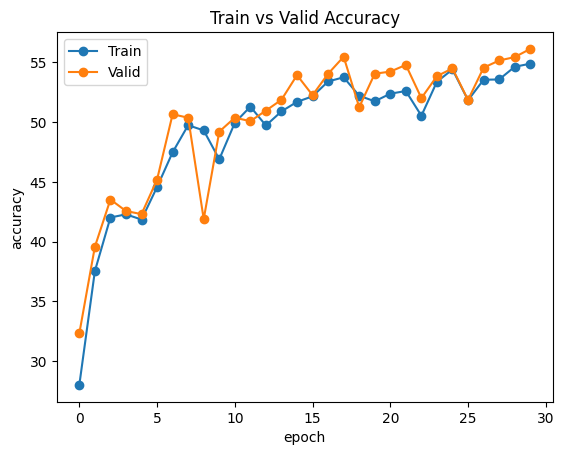

In [36]:
#plot accuracy
plt.plot(train_accu,'-o')
plt.plot(eval_accu,'-o')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Accuracy')

plt.show()

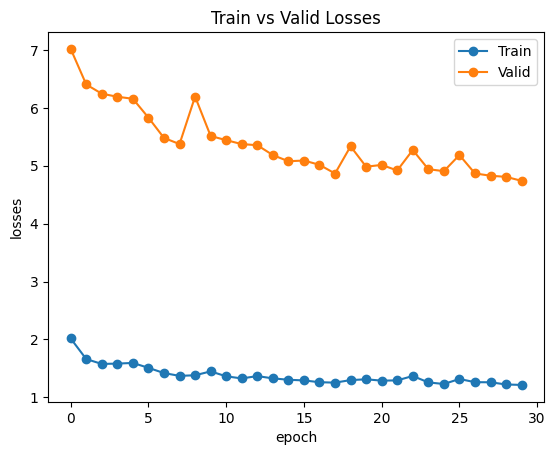

In [37]:
#plot losses

plt.plot(train_losses,'-o')
plt.plot(eval_losses,'-o')
plt.xlabel('epoch')
plt.ylabel('losses')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Losses')

plt.show()

In [38]:
from sklearn.metrics import confusion_matrix ,classification_report, precision_score, recall_score

# testing
ttloss = []
ttacc = []
ttf1 = []

T_val = []
P_val = []

with torch.no_grad():
    model.eval()
    for X_val, y_val, _ in tqdm(test_loader):
        X_val = X_val.float().cuda()
        X_val, y_val = X_val.to(device), y_val.to(device)
        #y_val = y_val.type(torch.cuda.LongTensor)

        output = model(X_val)
        #print(output.shape)

        outputs = torch.max(output, dim=1)[1]
        #print(outputs.shape)
        T_val.extend(y_val.cpu().numpy())
        #print(T_val)
        P_val.extend(outputs.cpu().numpy())
    #print(T_val)
    #print(P_val)
    precision = precision_score(T_val, P_val, average='macro')
    recall = recall_score(T_val, P_val, average='macro')
    res = confusion_matrix(T_val, P_val)
    report = classification_report(T_val, P_val)

    print("Precision: ",precision)
    print("Recall: ",recall)

    print('Confusion matrix:\n',res)
    print('Report:\n',report)


# with torch.no_grad():
#     model.eval()
#     for id, (X_val, y_val) in enumerate(val_data):
#         X_val, y_val = X_val.to(device), y_val.to(device)
#         y_val = y_val.type(torch.cuda.LongTensor)

#         output = model(X_val)
#         outputs = torch.max(output, dim=1)[1]
#         T_val.extend(y_val.cpu().numpy())
#         P_val.extend(outputs.cpu().numpy())
#     print(T_val)
#     print(P_val)
#     precision = precision_score(T_val, P_val, average='macro')
#     recall = recall_score(T_val, P_val, average='macro')
#     res = confusion_matrix(T_val, P_val)
#     report = classification_report(T_val, P_val)

#     print("Precision: ",precision)
#     print("Recall: ",recall)

#     print('Confusion matrix:\n',res)
#     print('Report:\n',report)

100%|██████████| 169/169 [00:04<00:00, 39.51it/s]

Precision:  0.6172759420387631
Recall:  0.5544666666666667
Confusion matrix:
 [[371   6  17  33  18  11  78  63   2   1]
 [ 34 290   2   6   7   1  75 171   1  13]
 [ 63  19 242  25  12  27  68 113  20  11]
 [118  25  17 130  31  21  41  98  18   1]
 [ 70   2   1  20 267   1  16 108  12   3]
 [ 79  20   9  11   8 174  55  36   7   1]
 [115   3  16  20   4  14 240  85   1   2]
 [ 28  10   2  21  24   4  93 403   4  11]
 [ 31   2   2  32  21   3   2  20 357  30]
 [  0   4   0   0   3   0   0  11  15 567]]
Report:
               precision    recall  f1-score   support

           0       0.41      0.62      0.49       600
           1       0.76      0.48      0.59       600
           2       0.79      0.40      0.53       600
           3       0.44      0.26      0.33       500
           4       0.68      0.53      0.60       500
           5       0.68      0.43      0.53       400
           6       0.36      0.48      0.41       500
           7       0.36      0.67      0.47      

In [39]:
# Assuming 'device' is defined as 'cuda' if a GPU is available, otherwise 'cpu'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
criterion = criterion.to(device)

# Train the model
for epoch in range(num_epochs):
    for images, landscape_labels, _ in tqdm(train_loader):
        # Transfer images and labels to the appropriate device
        images = images.to(device, dtype=torch.float)
        landscape_labels = landscape_labels.to(device, dtype=torch.long)  # Assuming labels are used for indexing, they should be long

        # Forward pass
        outputs = model(images)

        # Preparing labels for loss calculation (assuming cross-entropy loss which expects class indices as labels)
        # Assuming landscape_labels are class indices. If not, you need to preprocess them accordingly.

        # Calculate loss
        loss = criterion(outputs, landscape_labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Test the model
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, landscape_labels, _ in tqdm(test_loader):
            images = images.to(device, dtype=torch.float)
            landscape_labels = landscape_labels.to(device, dtype=torch.long)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            total += landscape_labels.size(0)
            correct += (predicted == landscape_labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Accuracy: {accuracy:.2f}%')
    model.train()



100%|██████████| 169/169 [00:04<00:00, 37.33it/s]


Epoch [1/10], Loss: 1.6463, Accuracy: 53.50%


100%|██████████| 169/169 [00:04<00:00, 37.92it/s]


Epoch [2/10], Loss: 1.1108, Accuracy: 55.69%


100%|██████████| 169/169 [00:04<00:00, 39.18it/s]


Epoch [3/10], Loss: 1.2576, Accuracy: 57.43%


100%|██████████| 169/169 [00:04<00:00, 39.83it/s]


Epoch [4/10], Loss: 1.5955, Accuracy: 51.74%


100%|██████████| 169/169 [00:04<00:00, 40.00it/s]


Epoch [5/10], Loss: 1.0705, Accuracy: 56.43%


100%|██████████| 169/169 [00:04<00:00, 40.39it/s]


Epoch [6/10], Loss: 1.4788, Accuracy: 55.09%


100%|██████████| 169/169 [00:04<00:00, 39.74it/s]


Epoch [7/10], Loss: 1.3346, Accuracy: 55.78%


100%|██████████| 169/169 [00:04<00:00, 38.51it/s]


Epoch [8/10], Loss: 1.5513, Accuracy: 55.22%


100%|██████████| 169/169 [00:04<00:00, 39.51it/s]


Epoch [9/10], Loss: 1.1856, Accuracy: 57.72%


100%|██████████| 169/169 [00:04<00:00, 39.44it/s]

Epoch [10/10], Loss: 1.1013, Accuracy: 56.44%


#Watermark Detection ViT

In [40]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

class WatermarkDetectorCNN(nn.Module):
    def __init__(self):
        super(WatermarkDetectorCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(13, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        # The feature map size depends on your input image size. Assuming an input size of (13, 64, 64),
        # the output size here would be (128, 8, 8) after three rounds of max pooling (2, 2) starting from 64x64.
        self.fc_layers = nn.Sequential(
            nn.Linear(128 * 8 * 8, 512),  # 128 channels, each 8x8 from the last pooling
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 2) # Output layer for binary classification
        )
    def forward(self, x):
        x = self.conv_layers(x)
        x = torch.flatten(x, start_dim=1)  # Flatten all dimensions except batch
        x = self.fc_layers(x)
        return x

In [41]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = WatermarkDetectorCNN().to(device)
# Initialize the CrossEntropyLoss function
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)


# Training loop
model.train()  # Set the model to training mode
num_epochs = 30
epoch_losses = []
all_labels = []
all_scores = []


for epoch in range(num_epochs):
    batch_losses = []
    for images, _, watermark_labels in tqdm(train_loader):  # Adjusted to ignore landscape labels
        images = images.to(device)
        watermark_labels = watermark_labels.to(device)  # Ensure labels are long integers
        watermark_labels = watermark_labels.long()
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, watermark_labels)  # Labels are class indices
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
        optimizer.step()

        batch_losses.append(loss.item())

    # Calculate and store the average loss for this epoch
    epoch_losses = np.mean(batch_losses)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_losses:.4f}')

100%|██████████| 675/675 [00:13<00:00, 50.19it/s]


Epoch [1/30], Loss: 0.0078


100%|██████████| 675/675 [00:13<00:00, 49.54it/s]


Epoch [2/30], Loss: 0.0028


100%|██████████| 675/675 [00:13<00:00, 51.06it/s]


Epoch [3/30], Loss: 0.0018


100%|██████████| 675/675 [00:13<00:00, 51.70it/s]


Epoch [4/30], Loss: 0.0003


100%|██████████| 675/675 [00:13<00:00, 51.85it/s]


Epoch [5/30], Loss: 0.0008


100%|██████████| 675/675 [00:13<00:00, 50.86it/s]


Epoch [6/30], Loss: 0.0000


100%|██████████| 675/675 [00:13<00:00, 50.44it/s]


Epoch [7/30], Loss: 0.0010


100%|██████████| 675/675 [00:13<00:00, 51.87it/s]


Epoch [8/30], Loss: 0.0000


100%|██████████| 675/675 [00:12<00:00, 52.14it/s]


Epoch [9/30], Loss: 0.0003


100%|██████████| 675/675 [00:13<00:00, 50.84it/s]


Epoch [10/30], Loss: 0.0014


100%|██████████| 675/675 [00:13<00:00, 50.75it/s]


Epoch [11/30], Loss: 0.0011


100%|██████████| 675/675 [00:13<00:00, 50.27it/s]


Epoch [12/30], Loss: 0.0009


100%|██████████| 675/675 [00:13<00:00, 51.90it/s]


Epoch [13/30], Loss: 0.0015


100%|██████████| 675/675 [00:13<00:00, 51.43it/s]


Epoch [14/30], Loss: 0.0000


100%|██████████| 675/675 [00:13<00:00, 51.12it/s]


Epoch [15/30], Loss: 0.0016


100%|██████████| 675/675 [00:13<00:00, 51.06it/s]


Epoch [16/30], Loss: 0.0020


100%|██████████| 675/675 [00:13<00:00, 50.70it/s]


Epoch [17/30], Loss: 0.0002


100%|██████████| 675/675 [00:13<00:00, 51.22it/s]


Epoch [18/30], Loss: 0.0006


100%|██████████| 675/675 [00:13<00:00, 50.17it/s]


Epoch [19/30], Loss: 0.0012


100%|██████████| 675/675 [00:13<00:00, 50.74it/s]


Epoch [20/30], Loss: 0.0005


100%|██████████| 675/675 [00:13<00:00, 51.81it/s]


Epoch [21/30], Loss: 0.0000


100%|██████████| 675/675 [00:13<00:00, 51.51it/s]


Epoch [22/30], Loss: 0.0000


100%|██████████| 675/675 [00:13<00:00, 51.53it/s]


Epoch [23/30], Loss: 0.0009


100%|██████████| 675/675 [00:13<00:00, 50.52it/s]


Epoch [24/30], Loss: 0.0000


100%|██████████| 675/675 [00:13<00:00, 51.30it/s]


Epoch [25/30], Loss: 0.0029


100%|██████████| 675/675 [00:12<00:00, 52.00it/s]


Epoch [26/30], Loss: 0.0007


100%|██████████| 675/675 [00:13<00:00, 51.10it/s]


Epoch [27/30], Loss: 0.0000


100%|██████████| 675/675 [00:13<00:00, 51.23it/s]


Epoch [28/30], Loss: 0.0001


100%|██████████| 675/675 [00:13<00:00, 50.73it/s]


Epoch [29/30], Loss: 0.0009


100%|██████████| 675/675 [00:13<00:00, 51.33it/s]

Epoch [30/30], Loss: 0.0000


In [42]:
_, predicted = torch.max(outputs, 1)  # Get the predicted classes
accuracy = (predicted == watermark_labels).float().mean()  # Calculate accuracy


In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), epoch_losses, marker='o', linestyle='-', color='b')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

In [ ]:
fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Watermark Detection')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

100%|██████████| 675/675 [00:11<00:00, 59.78it/s]


Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
AUC Score: 1.0


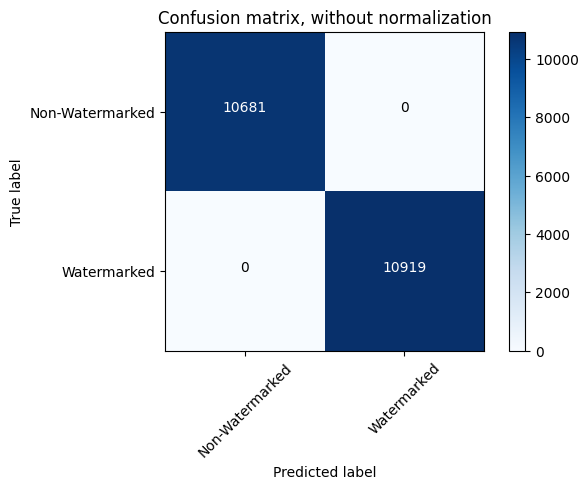

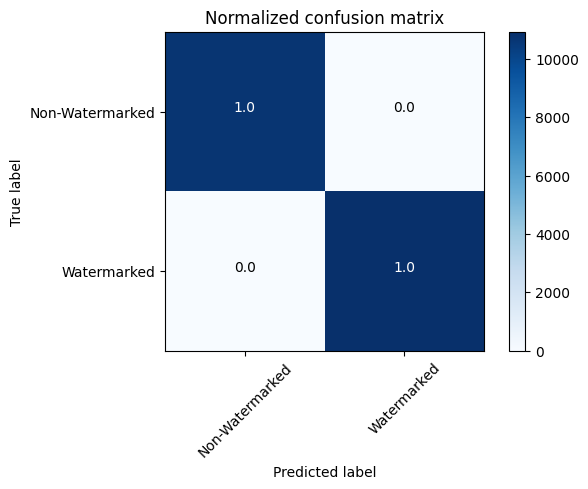

In [45]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve
import itertools

# Assuming you have 'test_loader' ready and the model is trained and moved to the correct device
model.eval()

all_labels = []
all_preds = []

with torch.no_grad():
    for images, _, watermark_labels in tqdm(train_loader):
        images = images.to(device)
        watermark_labels = watermark_labels.to(device)  # Ensure labels are long integers
        watermark_labels = watermark_labels.long()
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_labels.extend(watermark_labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

# Calculate metrics
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)
auc = roc_auc_score(all_labels, all_preds)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("AUC Score:", auc)

# Function to plot confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(all_labels, all_preds)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Non-Watermarked', 'Watermarked'],
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Non-Watermarked', 'Watermarked'], normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [46]:
import tifffile
def save_dataset_images(dataset, root_dir):
    labels = ['Forest', 'HerbaceousVegetation', 'AnnualCrop', 'Industrial', 'PermanentCrop', 'SeaLake', 'Residential', 'River', 'Pasture', 'Highway']

    # Ensure directory structure
    for label in labels:
        os.makedirs(os.path.join(root_dir, label, "watermarked"), exist_ok=True)
        os.makedirs(os.path.join(root_dir, label, "non_watermarked"), exist_ok=True)
        os.makedirs(os.path.join(root_dir, label, "generated"), exist_ok=True)

    # Initialize tqdm for visual progress bar
    pbar = tqdm(enumerate(dataset), total=len(dataset), desc="Saving images")

    for i, (image, landscape_label, watermark_label) in pbar:
        label_name = labels[landscape_label]
        subfolder = "watermarked" if watermark_label else "non_watermarked"
        file_path = os.path.join(root_dir, label_name, subfolder, f"{i}.tif")

        # Convert the PyTorch tensor to a NumPy array
        image_np = image.numpy()
        #image_np = np.transpose(image_np, (1, 2, 0))  # Change to HxWxC if necessary

        # Save the image as a TIFF
        tifffile.imwrite(file_path, image_np)

root_dir = "/content/EuroSAT_MS/"  # Make sure this is correctly set
save_dataset_images(train_dataset, root_dir)


Saving images: 100%|██████████| 21600/21600 [00:27<00:00, 788.46it/s]


## Maniulating Images

In [72]:
# import the required packages
import torch
import argparse
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image
from torchvision.utils import make_grid
from torch.utils.tensorboard import SummaryWriter
import datetime
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from torch.utils.tensorboard import SummaryWriter
from torchsummary import summary

In [73]:
import numpy as np
import torch
from torchvision import transforms
from torch.utils.data import Dataset
import tifffile

class ForestDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.files = []
        self.labels = []

        # Append all files in watermarked and non-watermarked directories
        for label_folder in ['watermarked', 'non_watermarked']:
            directory = os.path.join(root_dir, label_folder)
            for file in os.listdir(directory):
                if file.endswith('.tif'):
                    self.files.append(os.path.join(directory, file))
                    # Assign label: 0 for non_watermarked, 1 for watermarked
                    self.labels.append(1 if label_folder == 'watermarked' else 0)

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img_path = self.files[idx]
        label = self.labels[idx]

        # Load image with tifffile
        image = tifffile.imread(img_path)

        # Verify that the image has the expected number of channels
        if image.shape[0] != 13:
            raise ValueError(f"Image does not have 13 channels: {image.shape}")

        # Select RGB channels (2nd, 3rd, and 4th channels for RGB)
        # Assuming the image array is in the shape of (channels, height, width)
        image = image[1:4, :, :]  # Now image should have shape (3, H, W)

        # Convert the numpy array to a PyTorch tensor
        image = torch.from_numpy(image).float()

        # Normalize the image if a transform is provided
        if self.transform:
            image = self.transform(image)  # Apply the transform

        return image, label

# Define the normalization transform
transform = transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])

In [74]:
root_dir = '/content/EuroSAT_MS/Forest'  # Ensure this path is correct
forest_dataset = ForestDataset(root_dir=root_dir, transform=transform)
train_loader = DataLoader(forest_dataset, batch_size=32, shuffle=True)


In [75]:
# Get the first image and label from the dataset
image, label = forest_dataset[0]

# Print the shape; it should be in (C, H, W) format if you've already transposed it
print(image.shape)
# Check what the dataset returns directly
sample_image, sample_label = forest_dataset[0]
print(sample_image.shape)  # This should print (3, 64, 64) or similar
# Check the first batch from the DataLoader
for images, labels in train_loader:
    print(images.shape)  # What does this print?
    print(type(images))  # Ensure this is a tensor
    break


torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([32, 3, 64, 64])
<class 'torch.Tensor'>


In [76]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 16

In [77]:
image_shape = (3, 64, 64)
image_dim = int(np.prod(image_shape))
latent_dim = 100

In [78]:
num_class = len(train_loader.dataset.labels)
print('Training samples: ', len(train_loader)*batch_size)
print('number of batches: ', len(train_loader))

Training samples:  1200
number of batches:  75


In [79]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)

In [80]:
def show_images(images):
    fig, ax = plt.subplots(figsize=(20, 20))
    if images.max() > 1.0 or images.min() < 0.0:
            images = (images - images.min()) / (images.max() - images.min())
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(images.detach(), nrow=22).permute(1, 2, 0))

def show_batch(dl):
    for images, _ in dl:
        show_images(images)
        break

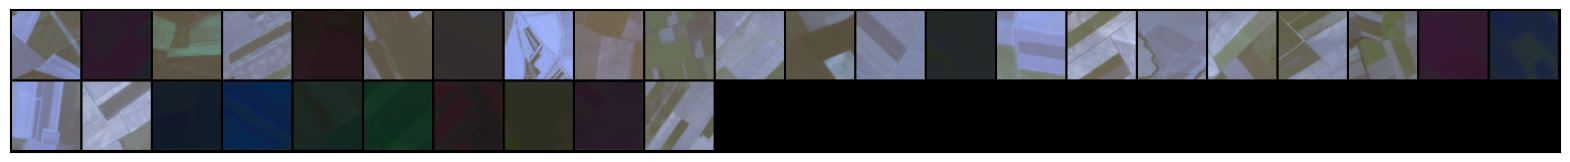

In [81]:
show_batch(train_loader)

In [82]:
# Generator Model Class Definition
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # Block 1:input is Z, going into a convolution
            nn.ConvTranspose2d(latent_dim, 64 * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(64 * 8),
            nn.ReLU(True),
            # Block 2: input is (64 * 8) x 4 x 4
            nn.ConvTranspose2d(64 * 8, 64 * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 4),
            nn.ReLU(True),
            # Block 3: input is (64 * 4) x 8 x 8
            nn.ConvTranspose2d(64 * 4, 64 * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 2),
            nn.ReLU(True),
            # Block 4: input is (64 * 2) x 16 x 16
            nn.ConvTranspose2d(64 * 2, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            # Block 5: input is (64) x 32 x 32
            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),
            nn.Tanh()
            # Output: output is (3) x 64 x 64
            )
    def forward(self, input):
        output = self.main(input)
        return output

In [83]:
# Discriminator Model Class Definition
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # Block 1: input is (3) x 64 x 64
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # Block 2: input is (64) x 32 x 32
            nn.Conv2d(64, 64 * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # Block 3: input is (64*2) x 16 x 16
            nn.Conv2d(64 * 2, 64 * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # Block 4: input is (64*4) x 8 x 8
            nn.Conv2d(64 * 4, 64 * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # Block 5: input is (64*8) x 4 x 4
            nn.Conv2d(64 * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid(),
            nn.Flatten()
            # Output: 1
            )
    def forward(self, input):
        output = self.main(input)
        return output

In [84]:
generator = Generator().to(device)
generator.apply(weights_init_normal)
print(generator)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [85]:
discriminator = Discriminator().to(device)
discriminator.apply(weights_init_normal)
print(discriminator)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
    (13): Flatten(start_dim=1, end_d

In [86]:
summary(generator, (100,1,1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 512, 4, 4]         819,200
       BatchNorm2d-2            [-1, 512, 4, 4]           1,024
              ReLU-3            [-1, 512, 4, 4]               0
   ConvTranspose2d-4            [-1, 256, 8, 8]       2,097,152
       BatchNorm2d-5            [-1, 256, 8, 8]             512
              ReLU-6            [-1, 256, 8, 8]               0
   ConvTranspose2d-7          [-1, 128, 16, 16]         524,288
       BatchNorm2d-8          [-1, 128, 16, 16]             256
              ReLU-9          [-1, 128, 16, 16]               0
  ConvTranspose2d-10           [-1, 64, 32, 32]         131,072
      BatchNorm2d-11           [-1, 64, 32, 32]             128
             ReLU-12           [-1, 64, 32, 32]               0
  ConvTranspose2d-13            [-1, 3, 64, 64]           3,072
             Tanh-14            [-1, 3,

In [87]:
summary(discriminator, (3,64,64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           3,072
         LeakyReLU-2           [-1, 64, 32, 32]               0
            Conv2d-3          [-1, 128, 16, 16]         131,072
       BatchNorm2d-4          [-1, 128, 16, 16]             256
         LeakyReLU-5          [-1, 128, 16, 16]               0
            Conv2d-6            [-1, 256, 8, 8]         524,288
       BatchNorm2d-7            [-1, 256, 8, 8]             512
         LeakyReLU-8            [-1, 256, 8, 8]               0
            Conv2d-9            [-1, 512, 4, 4]       2,097,152
      BatchNorm2d-10            [-1, 512, 4, 4]           1,024
        LeakyReLU-11            [-1, 512, 4, 4]               0
           Conv2d-12              [-1, 1, 1, 1]           8,192
          Sigmoid-13              [-1, 1, 1, 1]               0
          Flatten-14                   

In [88]:
adversarial_loss = nn.BCELoss()

In [89]:
def generator_loss(fake_output, label):
    gen_loss = adversarial_loss(fake_output, label)
    #print(gen_loss)
    return gen_loss

In [90]:
def discriminator_loss(output, label):
    disc_loss = adversarial_loss(output, label)
    return disc_loss

In [91]:
fixed_noise = torch.randn(128, latent_dim, 1, 1, device=device)
real_label = 1
fake_label = 0

In [92]:
learning_rate = 0.0002
G_optimizer = optim.Adam(generator.parameters(), lr = learning_rate, betas=(0.5, 0.999))
D_optimizer = optim.Adam(discriminator.parameters(), lr = learning_rate, betas=(0.5, 0.999))

In [93]:
num_epochs = 150
D_loss_plot, G_loss_plot = [], []

for epoch in range(1, num_epochs+1):
    D_loss_list, G_loss_list = [], []

    # Adjust enumeration to unpack all items from the loader
    for index, (real_images, _) in enumerate(train_loader):
        D_optimizer.zero_grad()
        real_images = real_images.to(device)

        # Prepare targets for the discriminator
        real_target = Variable(torch.ones(real_images.size(0), 1).to(device))  # Real images
        fake_target = Variable(torch.zeros(real_images.size(0), 1).to(device))  # Fake images

        # Discriminator loss on real images
        D_real_loss = discriminator_loss(discriminator(real_images), real_target)
        D_real_loss.backward()

        # Generate fake images
        noise_vector = torch.randn(real_images.size(0), latent_dim, 1, 1, device=device)
        generated_image = generator(noise_vector)

        # Discriminator loss on fake images
        output = discriminator(generated_image.detach())
        D_fake_loss = discriminator_loss(output, fake_target)
        D_fake_loss.backward()

        D_total_loss = D_real_loss + D_fake_loss
        D_loss_list.append(D_total_loss.item())

        D_optimizer.step()

        # Generator training
        G_optimizer.zero_grad()
        G_loss = generator_loss(discriminator(generated_image), real_target)
        G_loss.backward()
        G_optimizer.step()
        G_loss_list.append(G_loss.item())

    # Logging
    print(f'Epoch: [{epoch}/{num_epochs}]: D_loss: {np.mean(D_loss_list):.3f}, G_loss: {np.mean(G_loss_list):.3f}')
    D_loss_plot.append(np.mean(D_loss_list))
    G_loss_plot.append(np.mean(G_loss_list))

    # Saving generated images and model at the last epoch
    if epoch == 150:
        for i in range(generated_image.shape[0]):
            save_image(generated_image[i], f'/content/EuroSAT_MS/Forest/generated/{i}.png', normalize=True)
        torch.save(generator.state_dict(), f'/content/EuroSAT_MS/Forest/generator_epoch_{epoch}.pth')
        torch.save(discriminator.state_dict(), f'/content/EuroSAT_MS/Forest/discriminator_epoch_{epoch}.pth')

Epoch: [1/150]: D_loss: 0.156, G_loss: 11.555
Epoch: [2/150]: D_loss: 0.014, G_loss: 11.387
Epoch: [3/150]: D_loss: 0.279, G_loss: 25.021
Epoch: [4/150]: D_loss: 0.000, G_loss: 52.141
Epoch: [5/150]: D_loss: 0.000, G_loss: 52.078
Epoch: [6/150]: D_loss: 0.000, G_loss: 52.040
Epoch: [7/150]: D_loss: 0.000, G_loss: 52.018
Epoch: [8/150]: D_loss: 0.000, G_loss: 51.996
Epoch: [9/150]: D_loss: 0.000, G_loss: 51.979
Epoch: [10/150]: D_loss: 0.000, G_loss: 51.966
Epoch: [11/150]: D_loss: 0.000, G_loss: 51.955
Epoch: [12/150]: D_loss: 0.000, G_loss: 51.945
Epoch: [13/150]: D_loss: 0.000, G_loss: 51.926
Epoch: [14/150]: D_loss: 0.000, G_loss: 51.926
Epoch: [15/150]: D_loss: 0.000, G_loss: 51.919
Epoch: [16/150]: D_loss: 0.000, G_loss: 51.901
Epoch: [17/150]: D_loss: 0.000, G_loss: 51.888
Epoch: [18/150]: D_loss: 0.000, G_loss: 51.888
Epoch: [19/150]: D_loss: 0.000, G_loss: 51.884
Epoch: [20/150]: D_loss: 0.000, G_loss: 51.878
Epoch: [21/150]: D_loss: 0.000, G_loss: 51.873
Epoch: [22/150]: D_los